<h1>NetworkX Demo</h1>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import networkx as nx
import pylab as plt

import matplotlib as mpl
import matplotlib.cm as cm

from IPython.display import display
from lda_for_fragments import Ms2Lda
from visualisation.networkx.lda_visualisation import *

# get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

<h2>1. Load Data and apply thresholding</h2>

Load Beer3pos project used by Justin and apply thresholding below.

In [2]:
ms2lda = Ms2Lda.resume_from('results/Manuscript_Beer3POSmode_EFassignerALL.project')

Project loaded from results/Manuscript_Beer3POSmode_EFassignerALL.project time taken = 20.874765873
 - input_filenames = 
	../input/manuscript/Beer3pos_MS1filter_Method3_fragments.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_losses.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms1.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms2.csv
 - df.shape = (1422, 4496)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = 11/11/15 23:39:09
 - message = Beer3Pos analysis for the manuscript with EFassigner EF assignments for ms1, fragments, and losses


In [3]:
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

<h2>2. Create network graph</h2>

Specify the list of motifs of interest below. 

In [4]:
# all the highest-confidence motifs
# motifs_of_interest = [260, 262, 226, 158, 243, 127, 174, 59, 
#                       214, 60, 151, 40, 284, 276, 45, 79, 184, 
#                       130, 220, 55, 241, 13, 115, 162, 19, 58, 
#                       202, 131, 129, 222, 230, 67, 42, 116]

# smaller list
motifs_of_interest = [262, 158, 220, 55, 241, 115, 202, 226, 22]

In [5]:
G = get_network_graph(ms2lda, motifs_of_interest)
print "\n" + nx.info(G)

Removed 291 motifs from the graph because they're not in the list
Removed ['motif_22', 'motif_226'] from the graph because they don't share documents with other motifs in the list
Removed 1176 unconnected documents from the graph

Name: 
Type: Graph
Number of nodes: 253
Number of edges: 275
Average degree:   2.1739


So, when we create the graph *G*, we also filtered it in such a way that (1) only the motifs in the provided list are retained and additionally, (2) these motifs must have some documents shared with another motif.

Next, we draw a bipartite graph where the left side is the MS1 peaks (labelled by their peak ids) and the right side are the M2Ms. The graph has been filtered such that we only show MS1 peaks that are connected to at least *min_degree* number of Mass2Motifs. 

The number beside each motif (e.g. +25) shows how many other MS1 connected to it that we are not showing because there's no overlap with other motifs in the list.

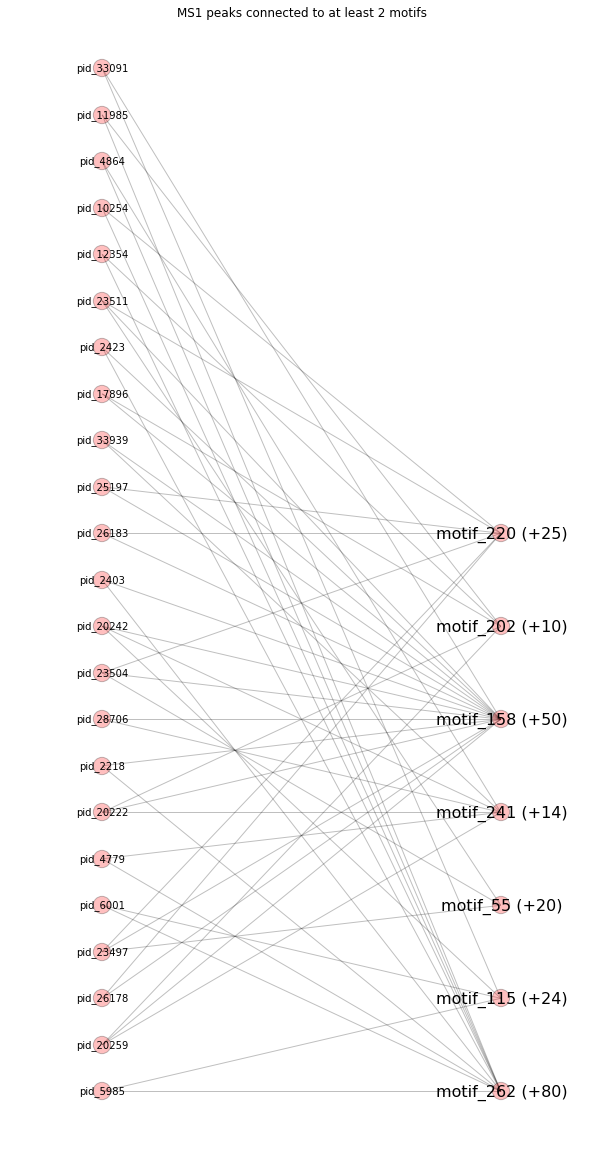

In [6]:
doc_nodes, doc_motifs, motif_idx = plot_bipartite(G, min_degree=2, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

# can tweak the fig_ and spacing_ parameters to adjust the plot appearance, especially if graph is dense
# doc_nodes, doc_motifs, motif_idx = plot_bipartite(G, min_degree=3, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

We can also plot the fragmentation spectra of these MS1 peaks of interest, coloring their MS2 peaks by the motifs. First, we set up some objects that would be used later.

In [7]:
# find out which words belong to which M2M
word_map = ms2lda.print_motif_features(selected_motifs=motifs_of_interest, quiet=True)

# read CSV annotation
motif_annotation = {}
for item in csv.reader(open("results/beer3pos_annotation.csv"), skipinitialspace=True):
    key = int(item[0])
    val = item[1]
    motif_annotation[key] = val
    
# map each motif to the colourmap too
# http://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.hires.png
norm = mpl.colors.Normalize(vmin=min(motif_idx.values()), vmax=max(motif_idx.values()))
cmap = cm.gist_rainbow
motif_colour = cm.ScalarMappable(norm=norm, cmap=cmap)

<h2>4. Example</h2>

Now we have everything we need to produce some nice plots! Here are some examples. First, I print the fragmentation spectra of MS1 with peak ID = 20259 and 28706. i selected these two fragmentation spectra from the list of all plots (in section 5) because they seem to show the strength of the LDA approach well.

Note: sometimes in the plot, the same MS2 peak generates a fragment word described by one topic in one colour and a loss word described by another topic in a different colour. In this case, the fragment word colour will win.

MS1 peakID 20259 mz 277.1585 rt 427.10 intensity 1081880.00 (C12H25O3N2S)
 - M2M_241	: Histidine substructure
 - M2M_202	: Tryptophan related substructure
 - M2M_158	: Leucine related substructure

Figure saved to results/example.png


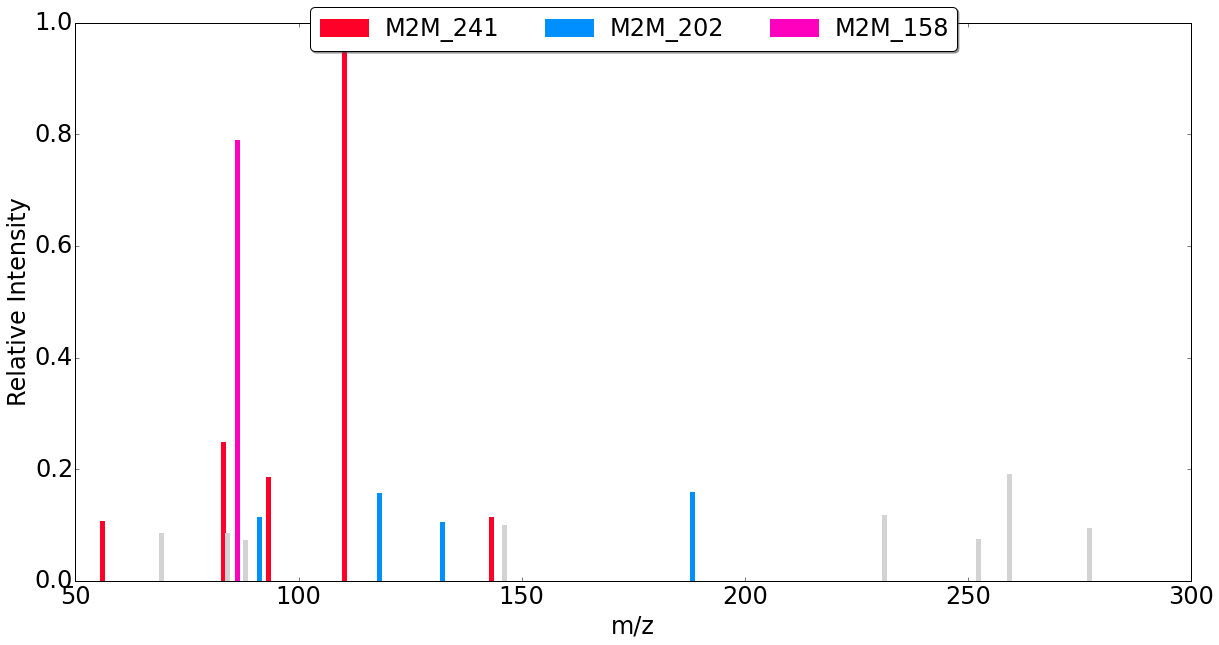

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
1,86.096443,0.786891,fragment_86.09652,158,loss_191.06155,241,"C5H12N,loss_C7H13O3NS"
5,188.070389,0.155427,fragment_188.07061,202,NaN,NaN,C11H10O2N
6,118.065384,0.153206,fragment_118.06544,202,NaN,NaN,C8H8N
8,91.053848,0.111245,fragment_91.05413,202,NaN,NaN,C7H7
11,132.081299,0.101629,fragment_132.08143,202,NaN,NaN,C9H10N
14,146.059235,0.086843,fragment_146.05935,202,NaN,NaN,C3H9N5P
0,110.071663,1.000000,fragment_110.07176,241,loss_167.08599,241,"C5H8N3,loss_C9H14NP"
2,83.060303,0.245350,fragment_83.06041,241,loss_194.09798,NaN,"C4H7N2,loss_C8H18O3S"
4,93.044960,0.182310,fragment_93.04509,241,NaN,NaN,C5H5N2
9,143.117538,0.111168,fragment_143.11757,241,NaN,NaN,C7H15ON2


In [8]:
# remove the save_to parameter if you don't want to save to file
df = print_report(ms2lda, G, 20259, motif_annotation, motif_colour, motif_idx, word_map, save_to='results/example.png')

display(df) # this line is used to display the table below the plot

MS1 peakID 28706 mz 362.2166 rt 503.15 intensity 643910.00 (C21H34NP2)
 - M2M_241	: Histidine substructure
 - M2M_158	: Leucine related substructure



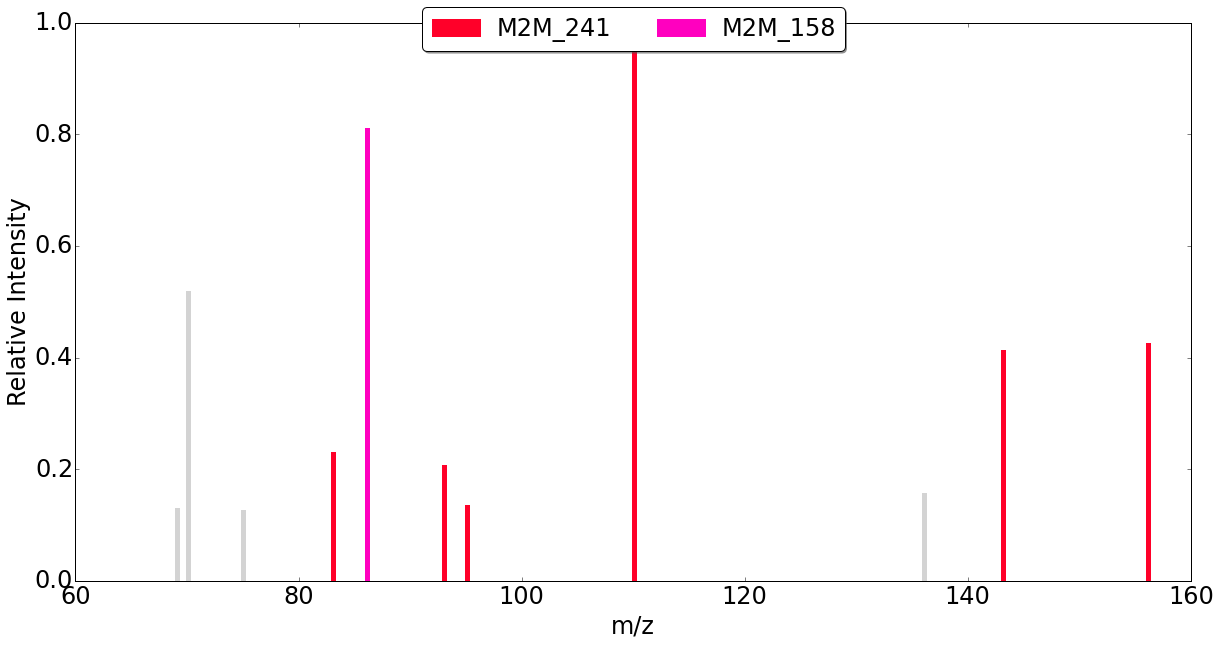

,ms2_mz,ms2_intensity,fragment_word,fragment_motif,loss_word,loss_motif,ef
1,86.096436,0.808129,fragment_86.09652,158,NaN,NaN,C5H12N
0,110.071678,1.000000,fragment_110.07176,241,NaN,NaN,C5H8N3
3,156.076584,0.422618,fragment_156.07684,241,NaN,NaN,C6H10O2N3
4,143.117432,0.409418,fragment_143.11757,241,NaN,NaN,C7H15ON2
5,83.060219,0.227476,fragment_83.06041,241,NaN,NaN,C4H7N2
6,93.045021,0.203294,fragment_93.04509,241,NaN,NaN,C5H5N2
8,95.060776,0.131635,fragment_95.06076,241,NaN,NaN,C5H7N2
2,70.065140,0.516424,fragment_70.06514,NaN,NaN,NaN,C4H8N
7,136.062393,0.153296,fragment_136.06239,NaN,NaN,NaN,C5H6N5
9,69.070091,0.126085,fragment_69.07013,NaN,NaN,NaN,C5H9


In [9]:
df = print_report(ms2lda, G, 28706, motif_annotation, motif_colour, motif_idx, word_map)
display(df)

We also want to show other fragmentation spectra from M2M 241 for comparison. To do this, we need to get the peak IDS of all the MS1 peaks connected to this motif.

Peak IDs of all MS1 connected to M2M 241 = set([4864, 449, 28706, 20259, 14469, 4839, 24713, 4779, 14514, 28718, 14424, 20242, 33939, 9236, 29110, 25207, 19224, 33172, 16731, 9533, 20222])

MS1 peakID 24713 mz 310.2125 rt 240.35 intensity 1472855.38 (C16H28O3N3)
 - M2M_241	: Histidine substructure



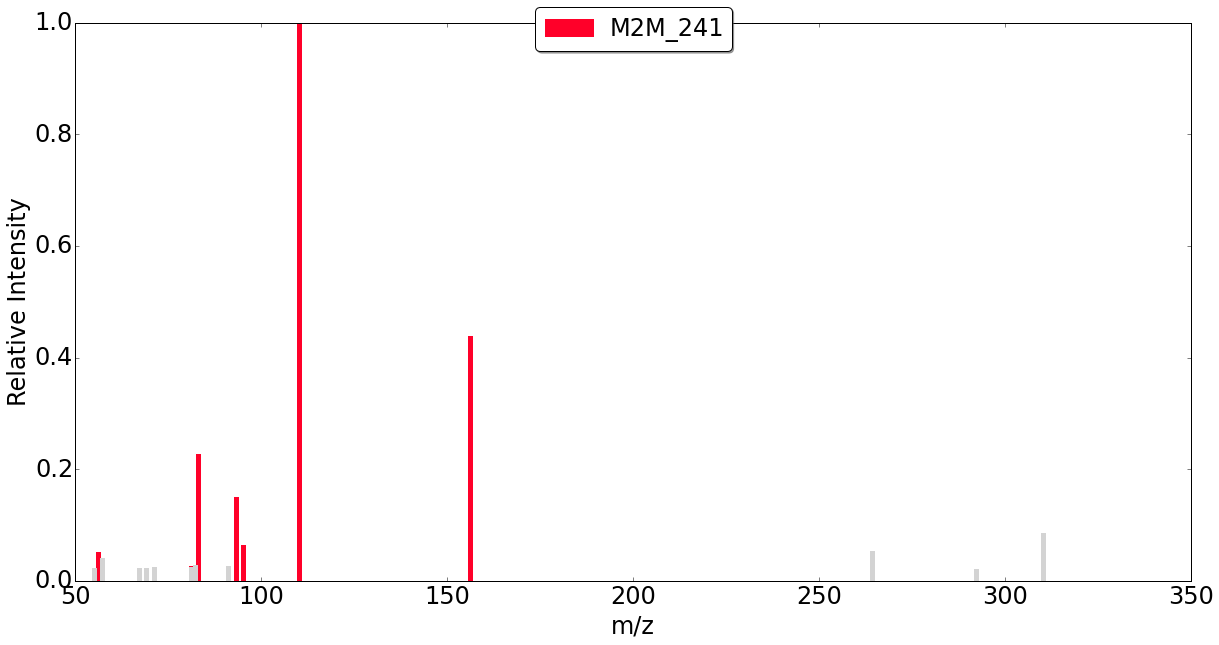

MS1 peakID 16731 mz 251.1499 rt 409.09 intensity 2320696.00 (C12H27OS2)
 - M2M_241	: Histidine substructure



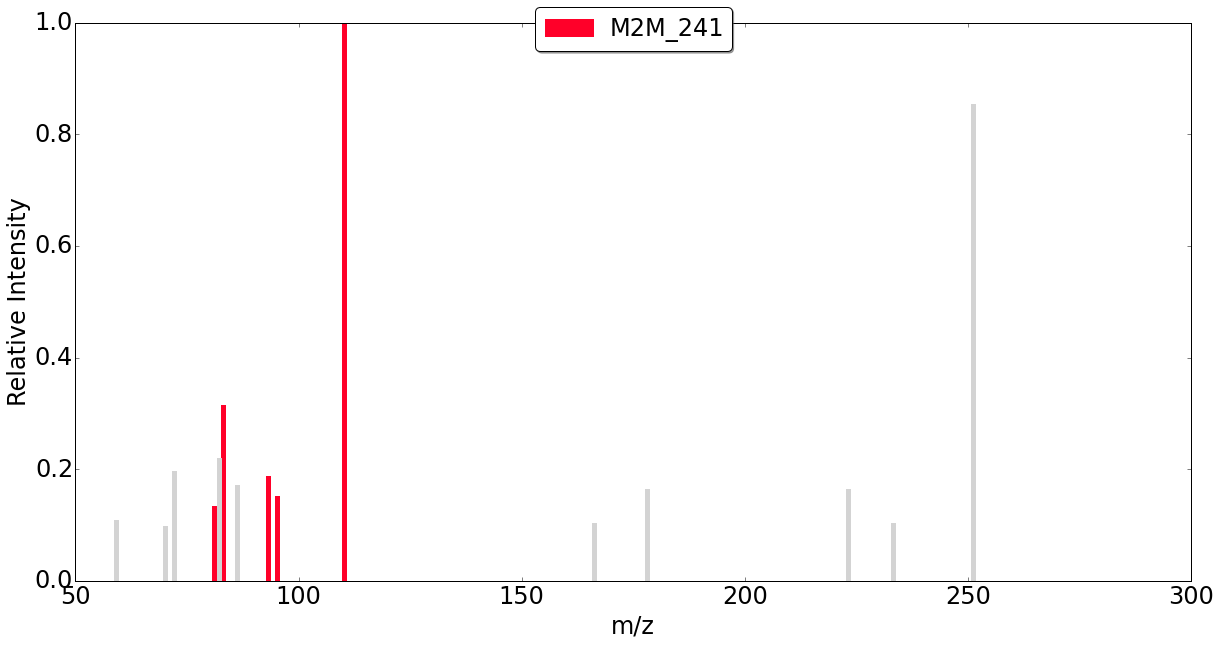

In [10]:
print "Peak IDs of all MS1 connected to M2M 241 = %s" % get_peak_ids_of_m2m(G, 241)
print

# pick any one from the list printed above
df = print_report(ms2lda, G, 24713, motif_annotation, motif_colour, motif_idx, word_map)
df = print_report(ms2lda, G, 16731, motif_annotation, motif_colour, motif_idx, word_map)

And some examples for M2M 202.

Peak IDs of all MS1 connected to M2M 202 = set([12354, 20259, 8772, 17896, 10474, 8336, 11985, 10706, 30163, 22068, 20222, 3513, 26266, 10364, 14846])

MS1 peakID 8336 mz 188.0706 rt 553.53 intensity 13060257.00 (C11H10O2N)
 - M2M_202	: Tryptophan related substructure



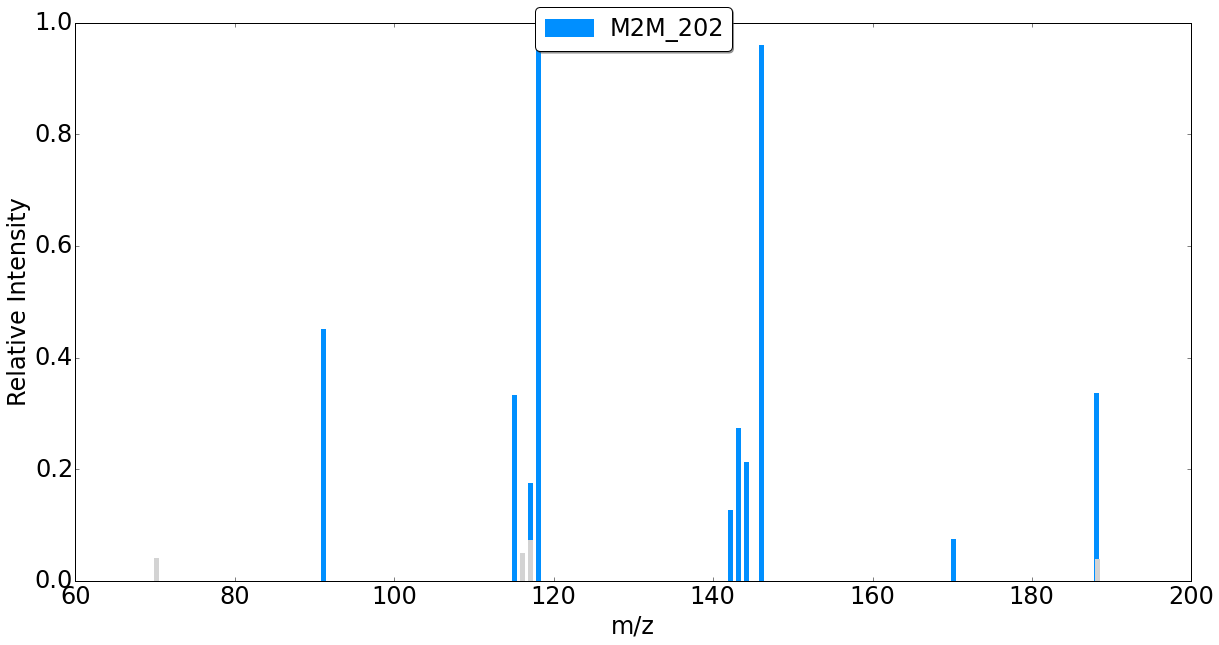

MS1 peakID 26266 mz 334.1398 rt 541.00 intensity 1385774.88 (C18H25ONPS)
 - M2M_202	: Tryptophan related substructure



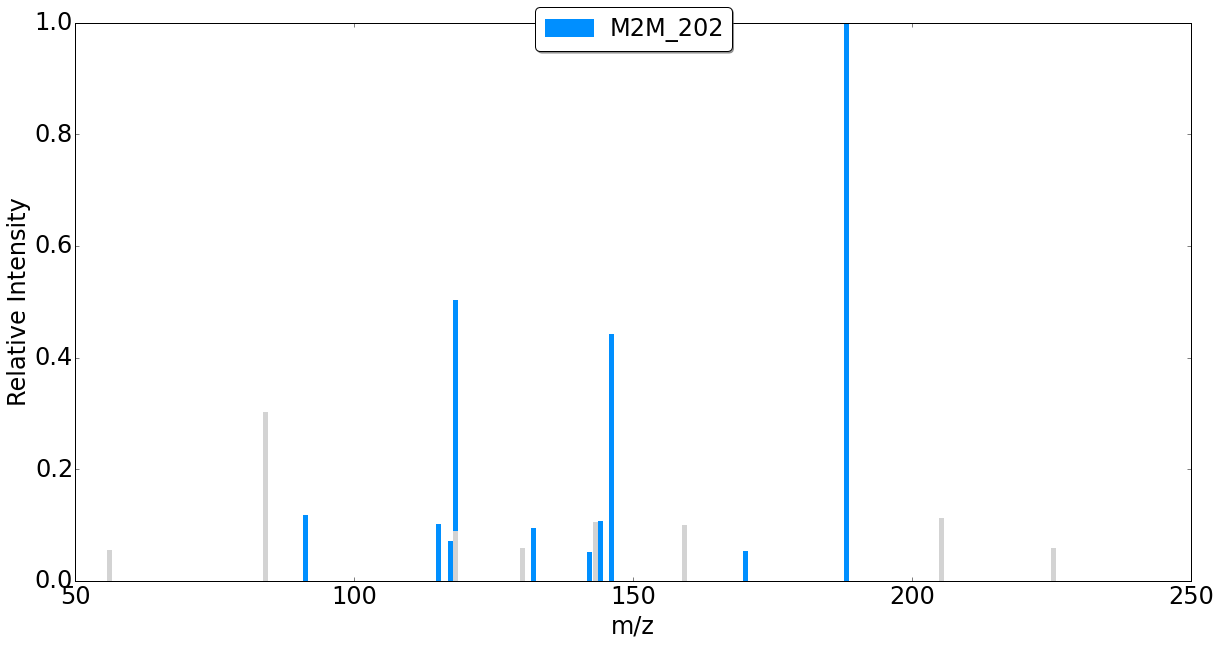

In [11]:
print "Peak IDs of all MS1 connected to M2M 202 = %s" % get_peak_ids_of_m2m(G, 202)
print

# pick any one from the list printed above
df = print_report(ms2lda, G, 8336, motif_annotation, motif_colour, motif_idx, word_map)
df = print_report(ms2lda, G, 26266, motif_annotation, motif_colour, motif_idx, word_map)

And some examples for M2M 158.

Peak IDs of all MS1 connected to M2M 158 = set([33420, 11267, 31876, 2443, 28556, 3610, 25197, 33967, 20242, 2323, 3477, 14230, 14104, 2457, 28570, 32027, 17564, 27037, 28706, 20259, 28581, 2470, 23580, 2218, 26183, 33964, 33650, 17967, 34352, 17713, 13613, 23497, 31802, 17729, 26178, 33091, 5190, 32199, 11209, 32714, 30540, 3661, 78, 23504, 17873, 82, 15651, 23511, 19674, 93, 7901, 2403, 23526, 26705, 17896, 30570, 33644, 26349, 19438, 2290, 33939, 7925, 2423, 27001, 13564, 20222])

MS1 peakID 28556 mz 359.1035 rt 287.88 intensity 668161.62 (C21H15O4N2)
 - M2M_158	: Leucine related substructure



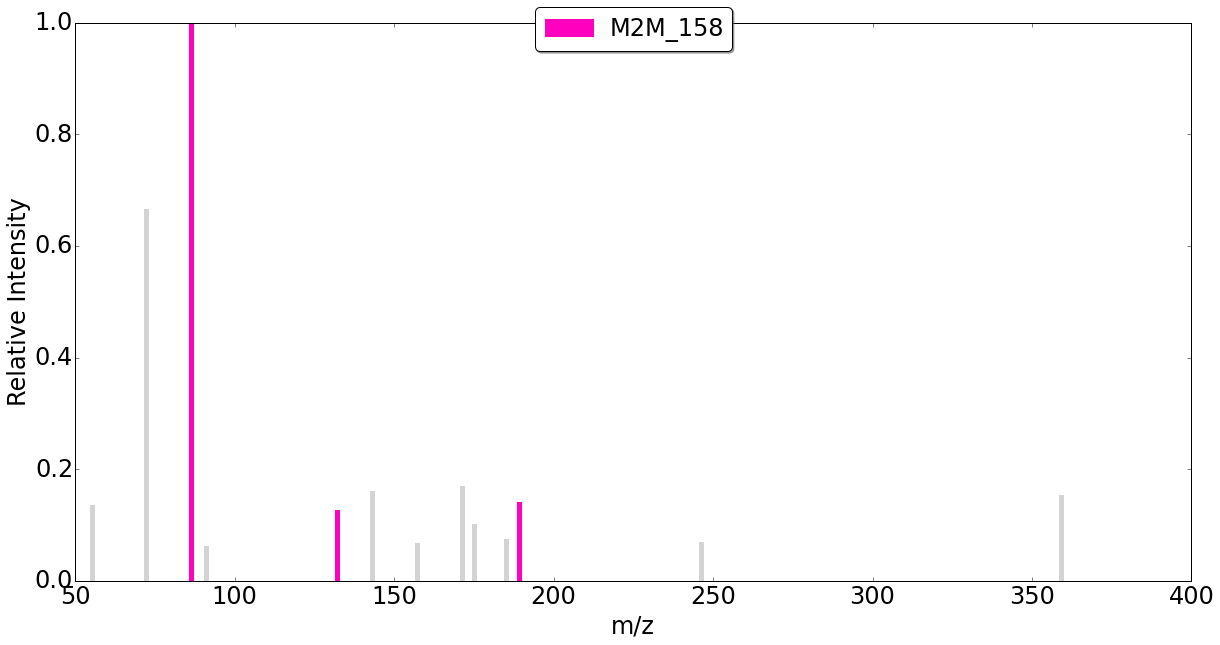

MS1 peakID 33420 mz 502.2499 rt 517.27 intensity 1322565.50 (nan)
 - M2M_158	: Leucine related substructure



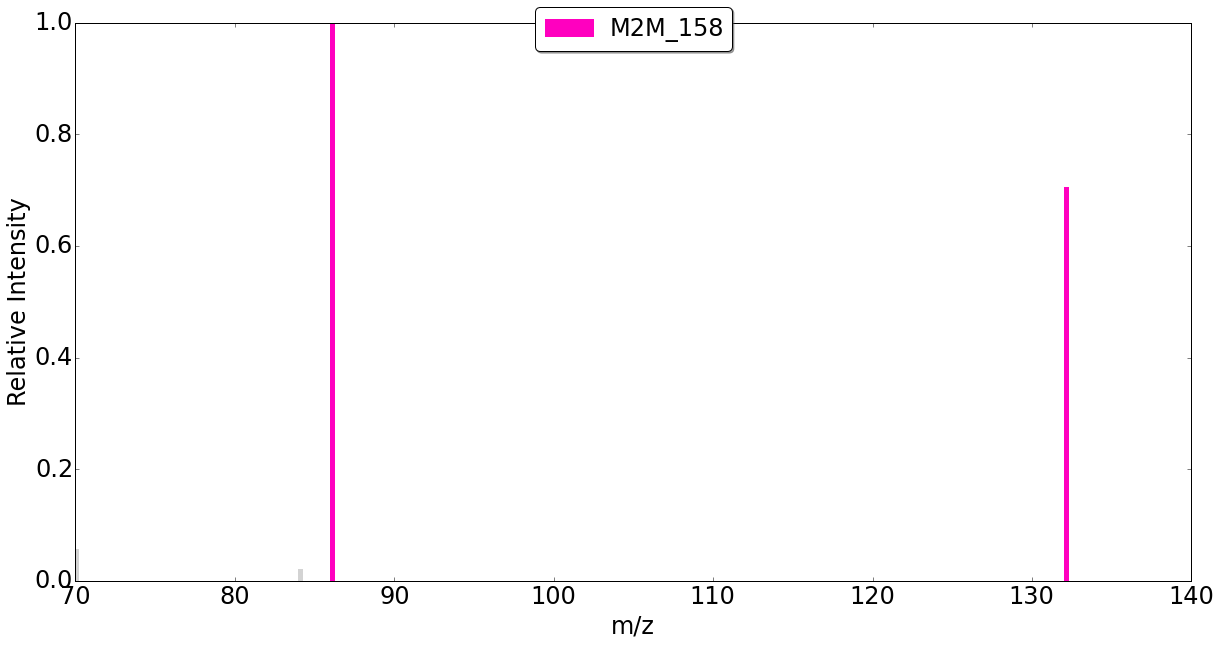

In [27]:
print "Peak IDs of all MS1 connected to M2M 158 = %s" % get_peak_ids_of_m2m(G, 158)
print

# pick any one from the list printed above
df = print_report(ms2lda, G, 28556, motif_annotation, motif_colour, motif_idx, word_map)
df = print_report(ms2lda, G, 33420, motif_annotation, motif_colour, motif_idx, word_map)

<h2>5. More Examples</h2>

Use the following to find the intersection of the documents shared by any topics.

In [12]:
peak_ids1 = get_peak_ids_of_m2m(G, 115)
peak_ids2 = get_peak_ids_of_m2m(G, 262)
overlap = peak_ids1.intersection(peak_ids2)

print overlap

set([5985, 6001])


The following plots all the MS1 nodes of interest (degree > min_degree) in the bipartite graph

MS1 peakID 5985 mz 166.0863 rt 377.30 intensity 880995.75 (C9H12O2N)
 - M2M_115	: [phenylalanine-COOH] based substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



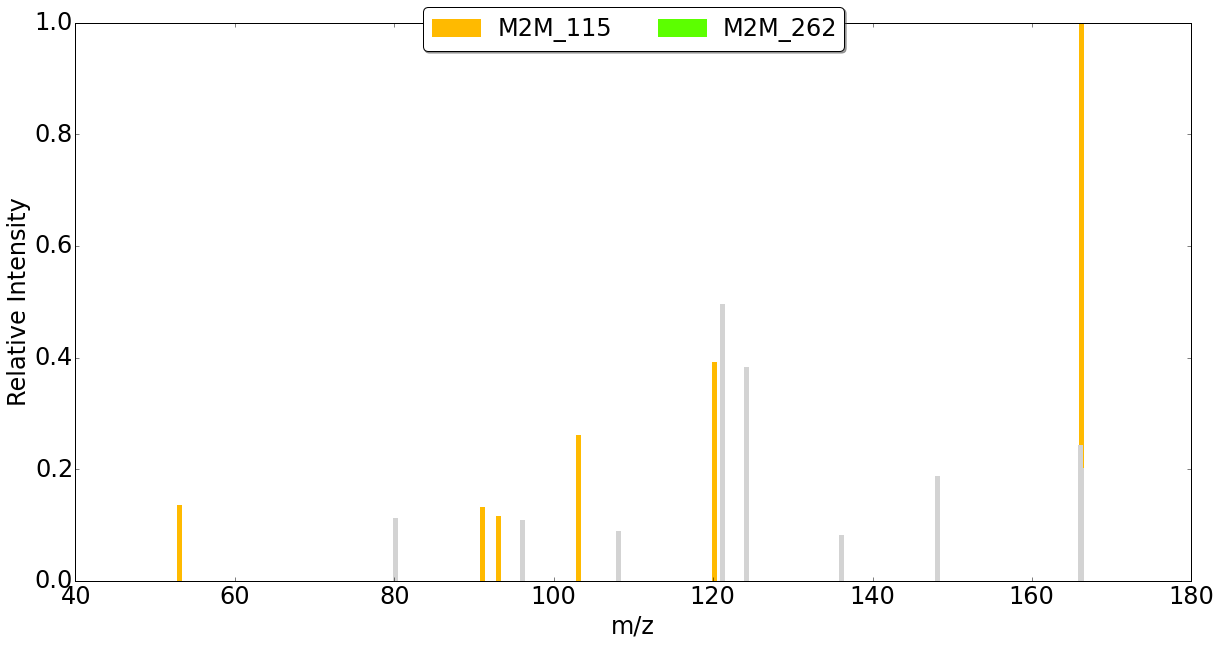

MS1 peakID 20259 mz 277.1585 rt 427.10 intensity 1081880.00 (C12H25O3N2S)
 - M2M_241	: Histidine substructure
 - M2M_202	: Tryptophan related substructure
 - M2M_158	: Leucine related substructure



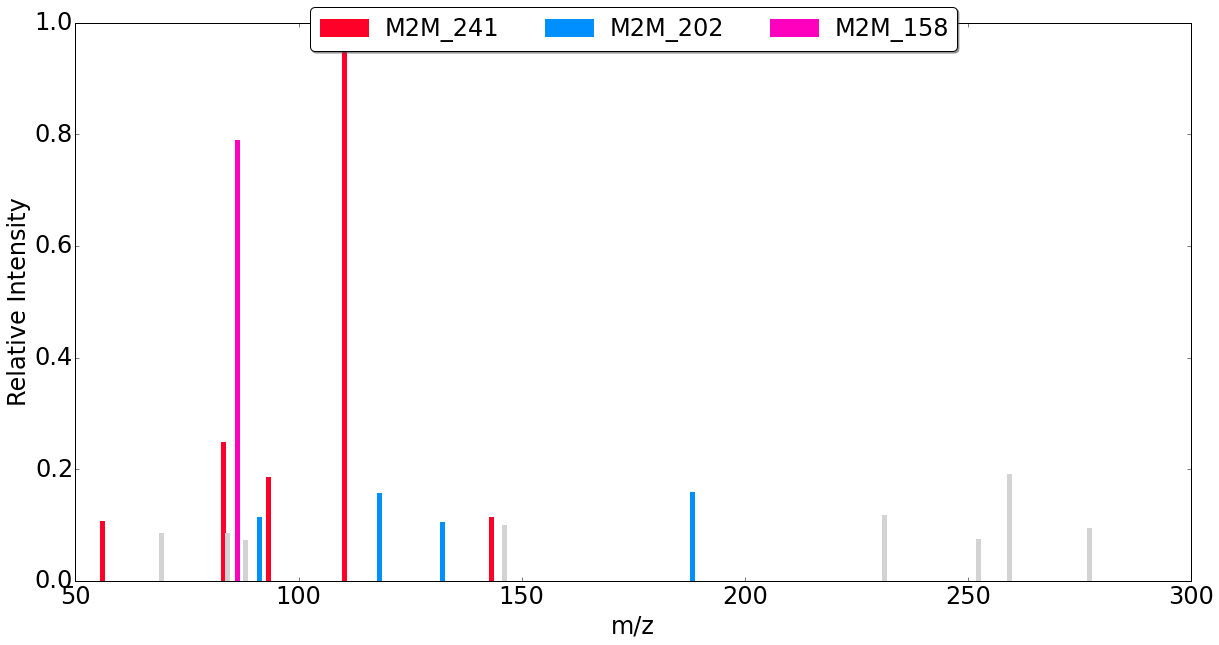

MS1 peakID 26178 mz 332.1106 rt 462.11 intensity 1729951.00 (C13H22O3N3S2)
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure



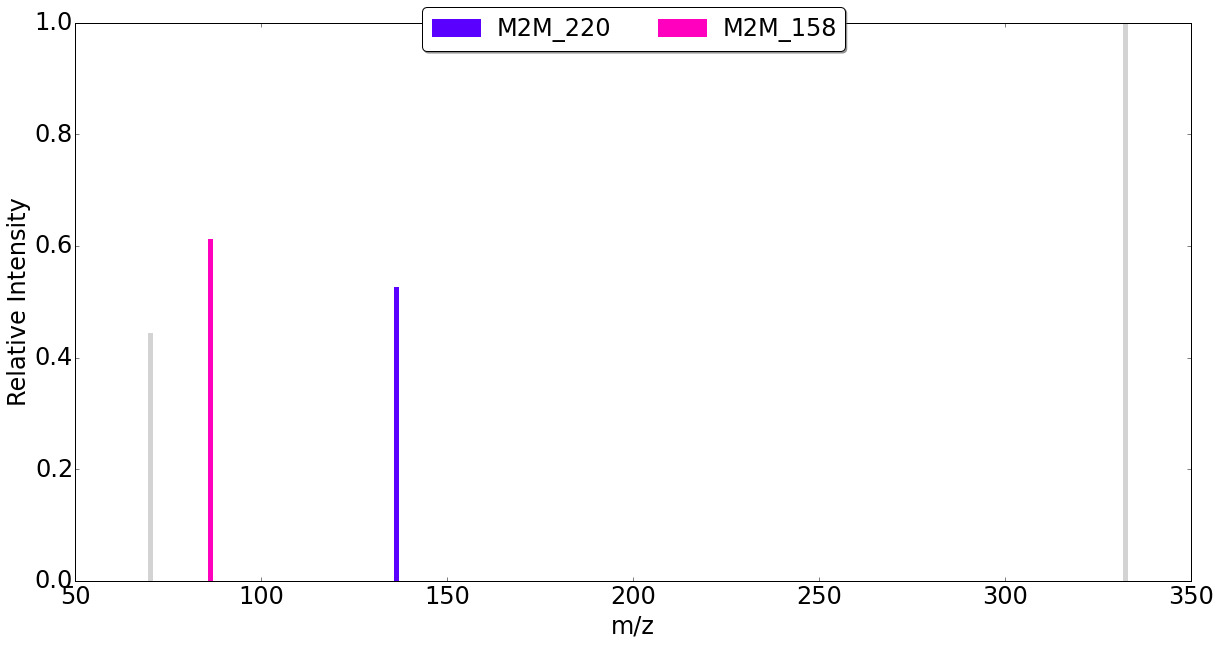

MS1 peakID 23497 mz 300.0844 rt 370.65 intensity 1123364.25 (C20H14NS)
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure
 - M2M_55	: Cinnamic acid (cinnamate) substructure



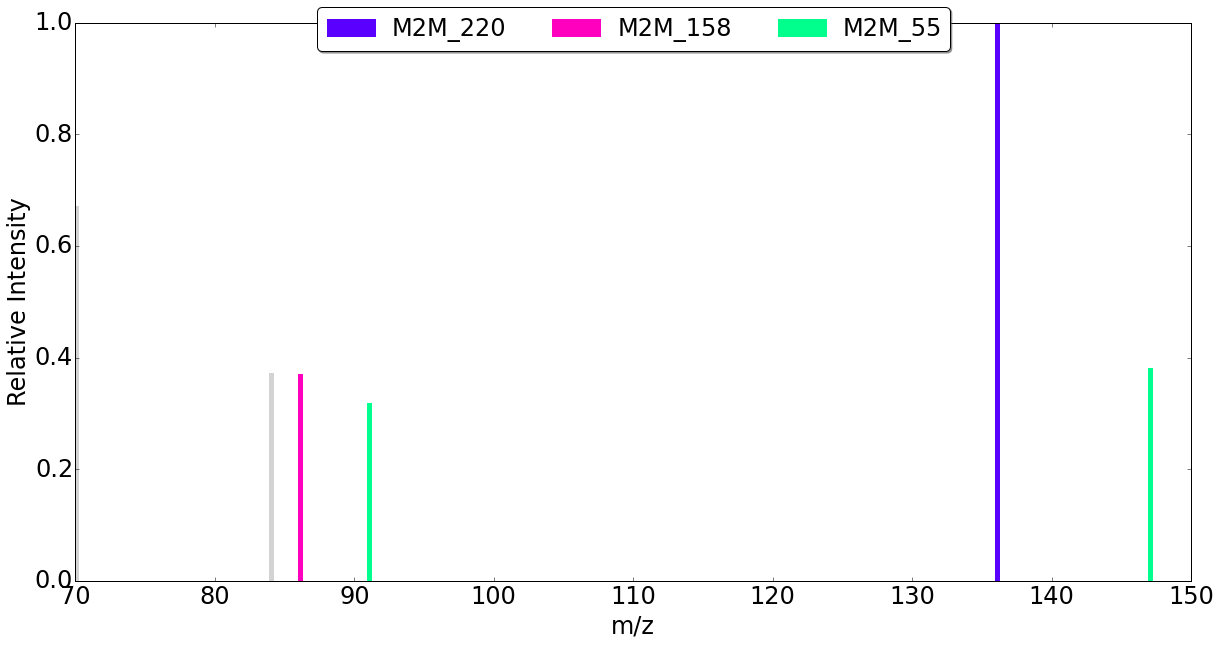

MS1 peakID 6001 mz 166.0863 rt 499.24 intensity 15979306.00 (C9H12O2N)
 - M2M_115	: [phenylalanine-COOH] based substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



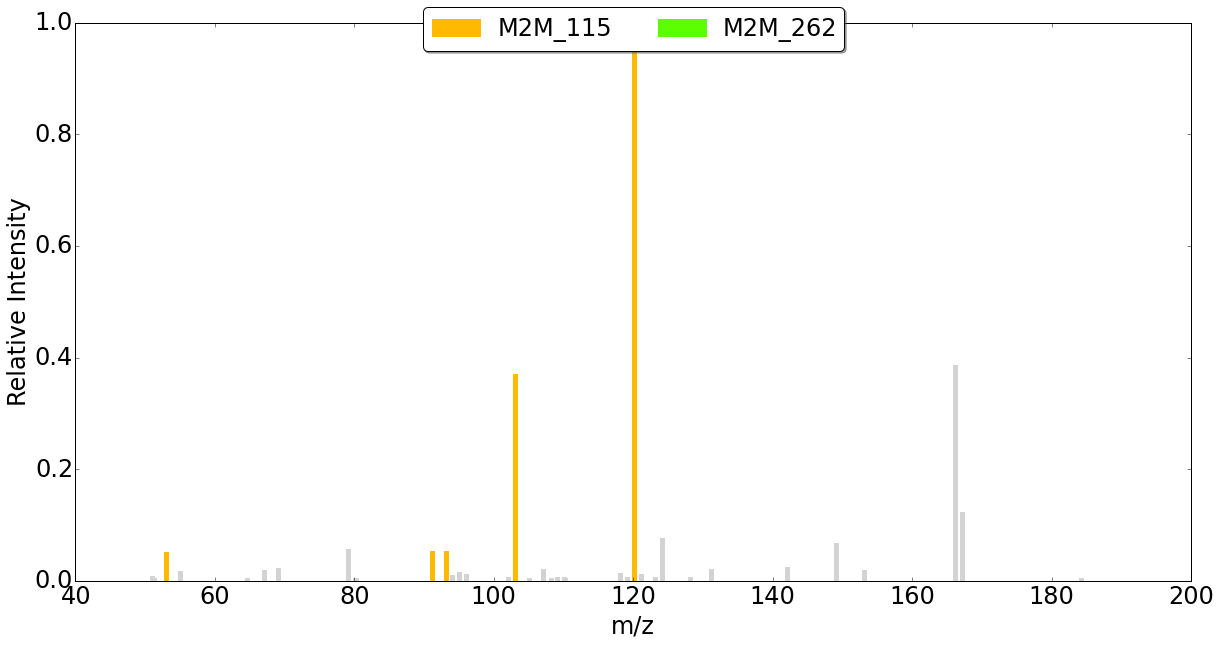

MS1 peakID 4779 mz 156.0768 rt 621.07 intensity 110043960.00 (C6H10O2N3)
 - M2M_241	: Histidine substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



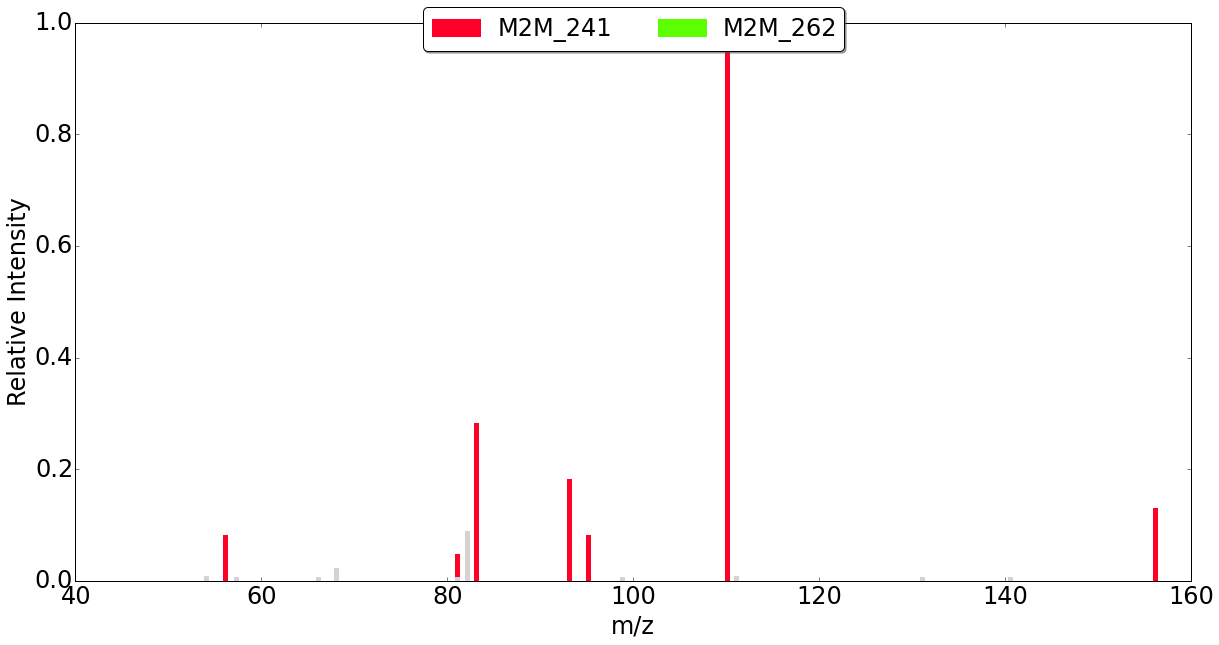

MS1 peakID 20222 mz 277.1474 rt 435.83 intensity 520255.16 (C13H25O4S)
 - M2M_241	: Histidine substructure
 - M2M_202	: Tryptophan related substructure
 - M2M_158	: Leucine related substructure



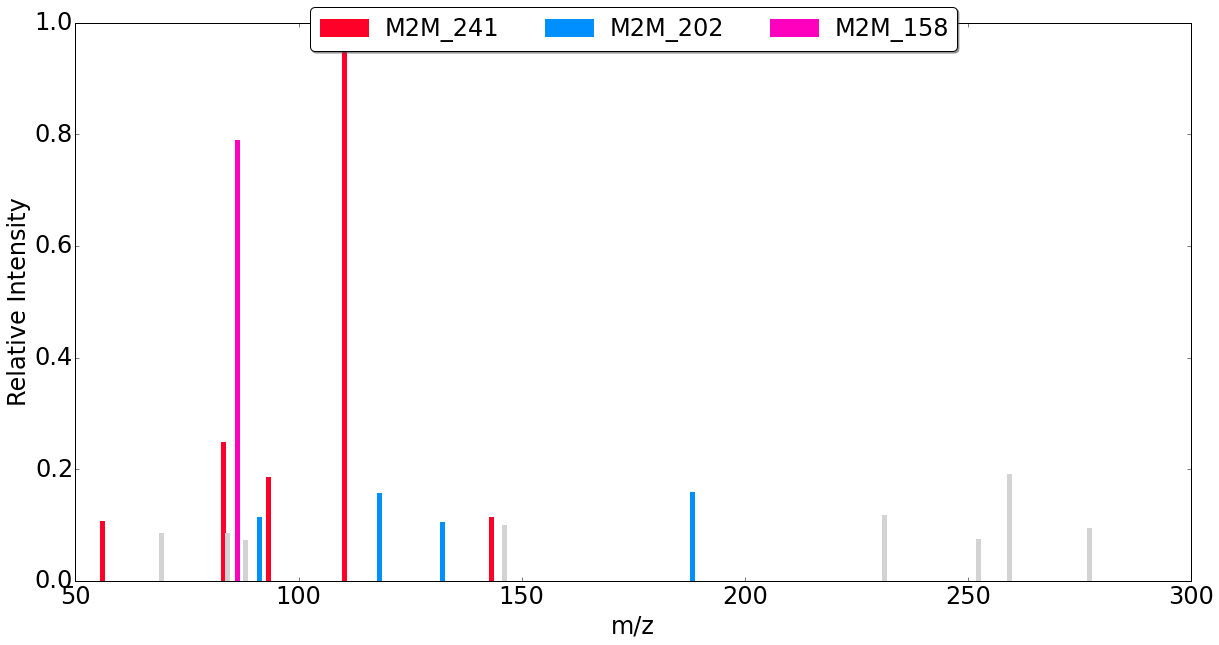

MS1 peakID 2218 mz 132.0541 rt 484.00 intensity 1776054.25 (nan)
 - M2M_158	: Leucine related substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



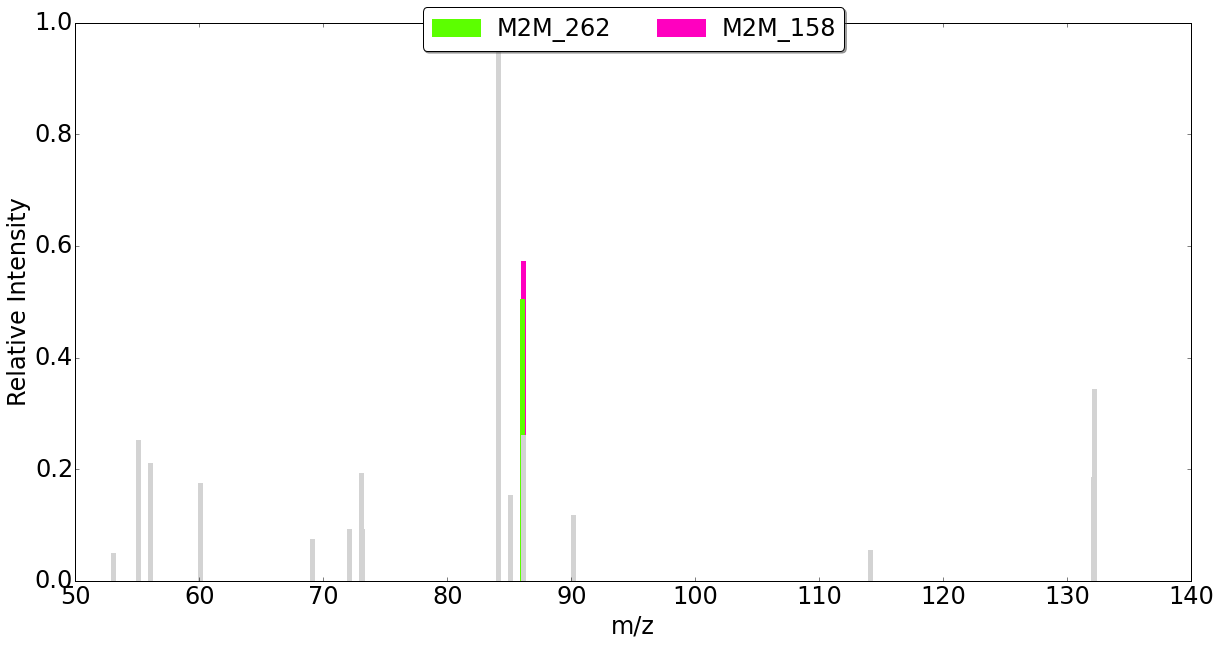

MS1 peakID 28706 mz 362.2166 rt 503.15 intensity 643910.00 (C21H34NP2)
 - M2M_241	: Histidine substructure
 - M2M_158	: Leucine related substructure



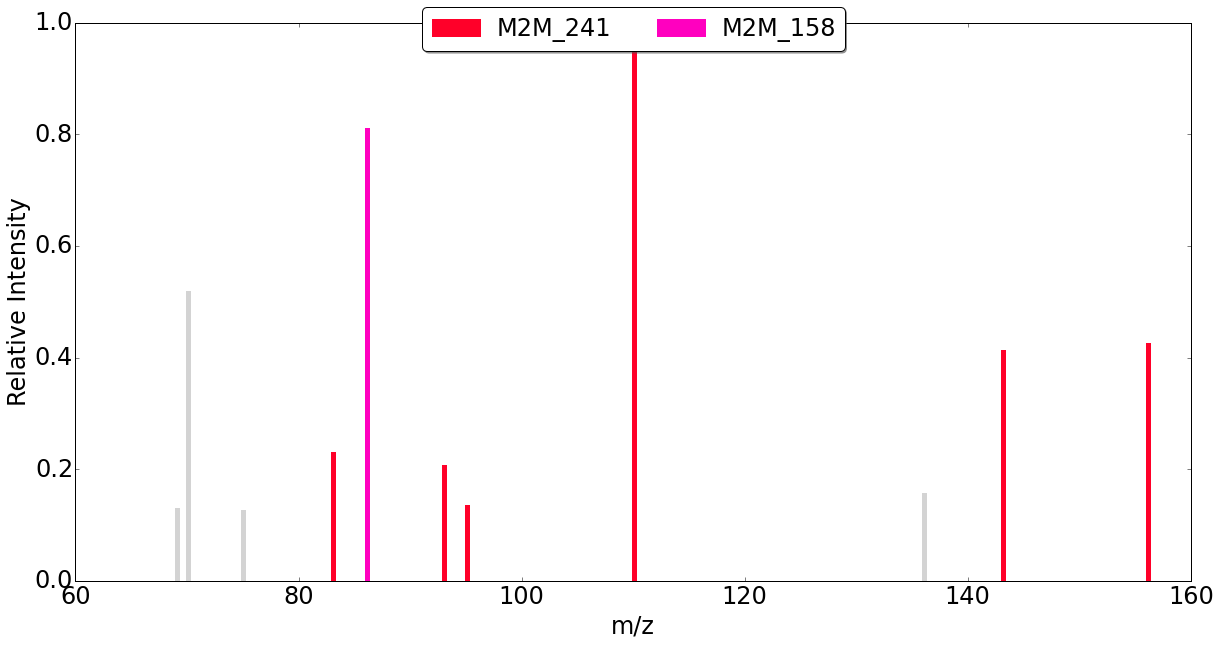

MS1 peakID 23504 mz 300.0844 rt 381.02 intensity 1712000.25 (C20H14NS)
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure
 - M2M_55	: Cinnamic acid (cinnamate) substructure



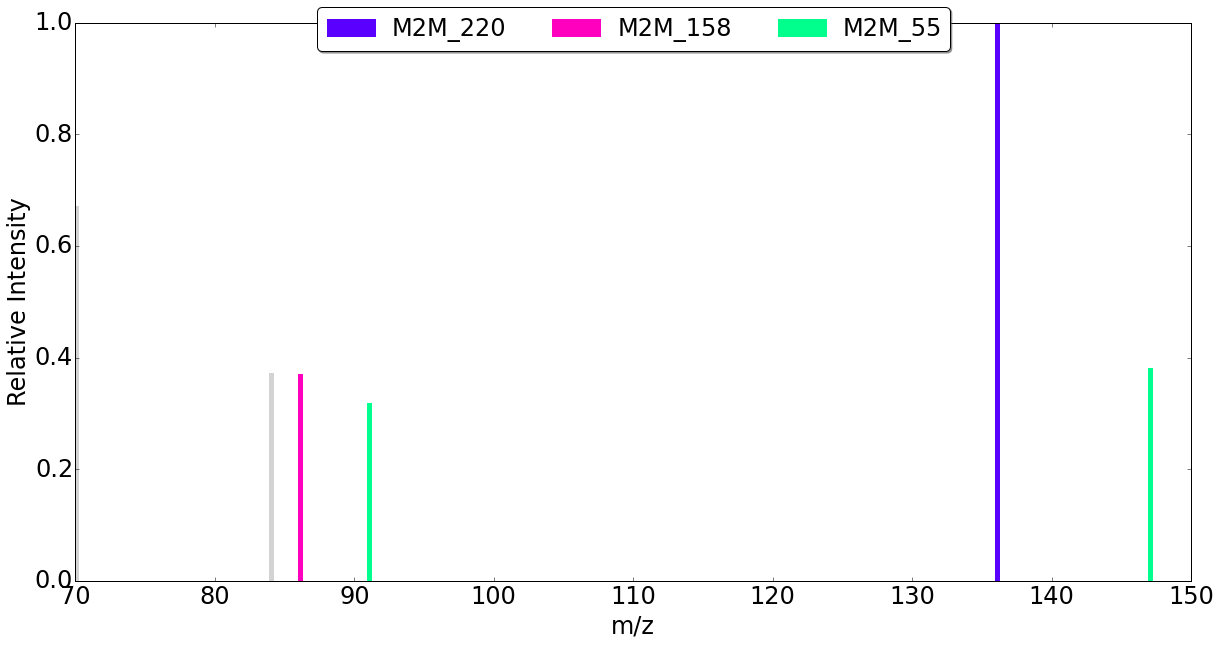

MS1 peakID 20242 mz 277.1582 rt 304.98 intensity 1053594.50 (C14H22N4P)
 - M2M_241	: Histidine substructure
 - M2M_115	: [phenylalanine-COOH] based substructure
 - M2M_158	: Leucine related substructure



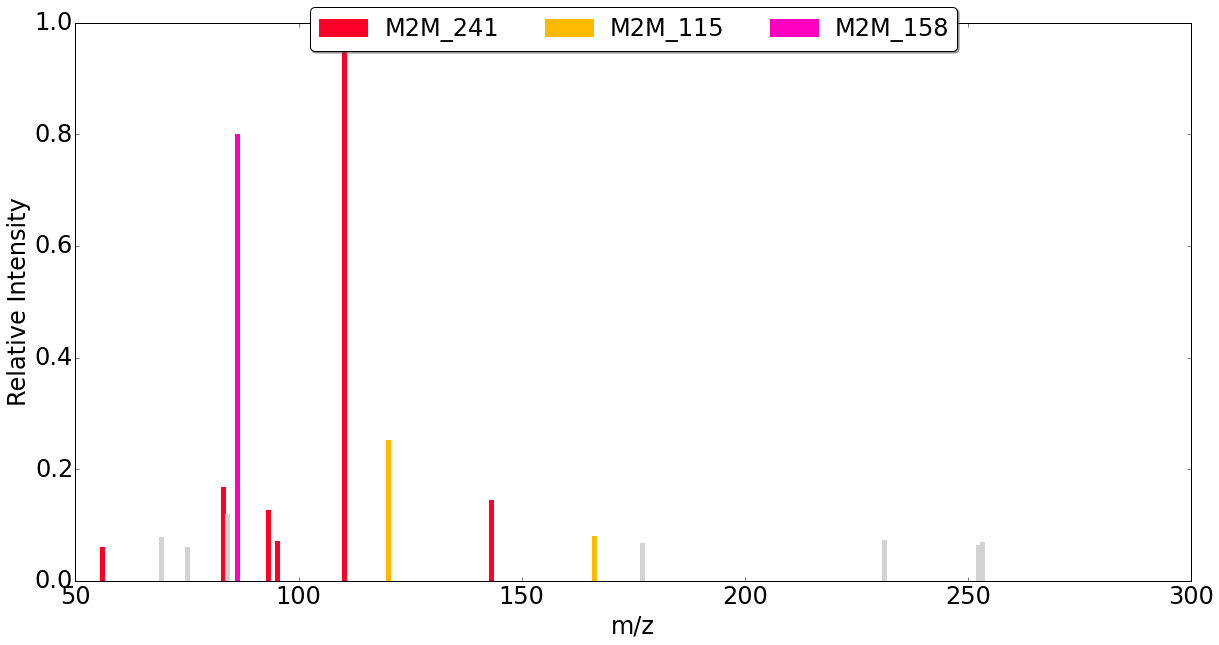

MS1 peakID 2403 mz 132.1019 rt 519.74 intensity 28418200.00 (C6H14O2N)
 - M2M_158	: Leucine related substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



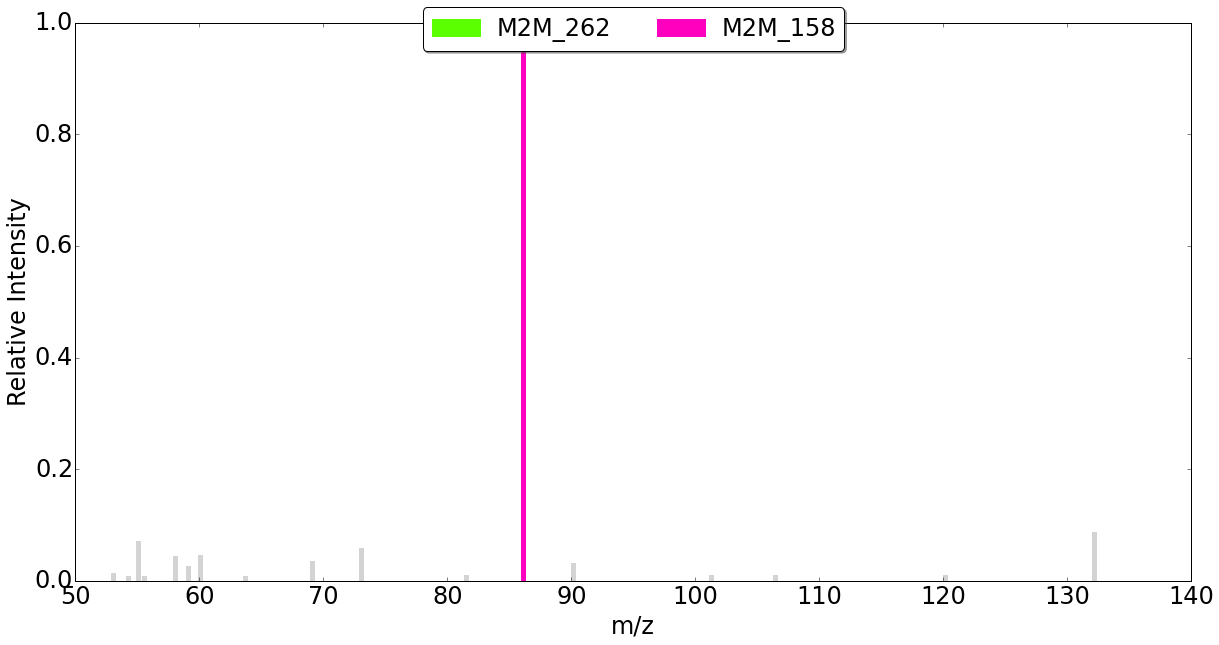

MS1 peakID 26183 mz 332.1106 rt 448.38 intensity 1373344.50 (C13H22O3N3S2)
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure



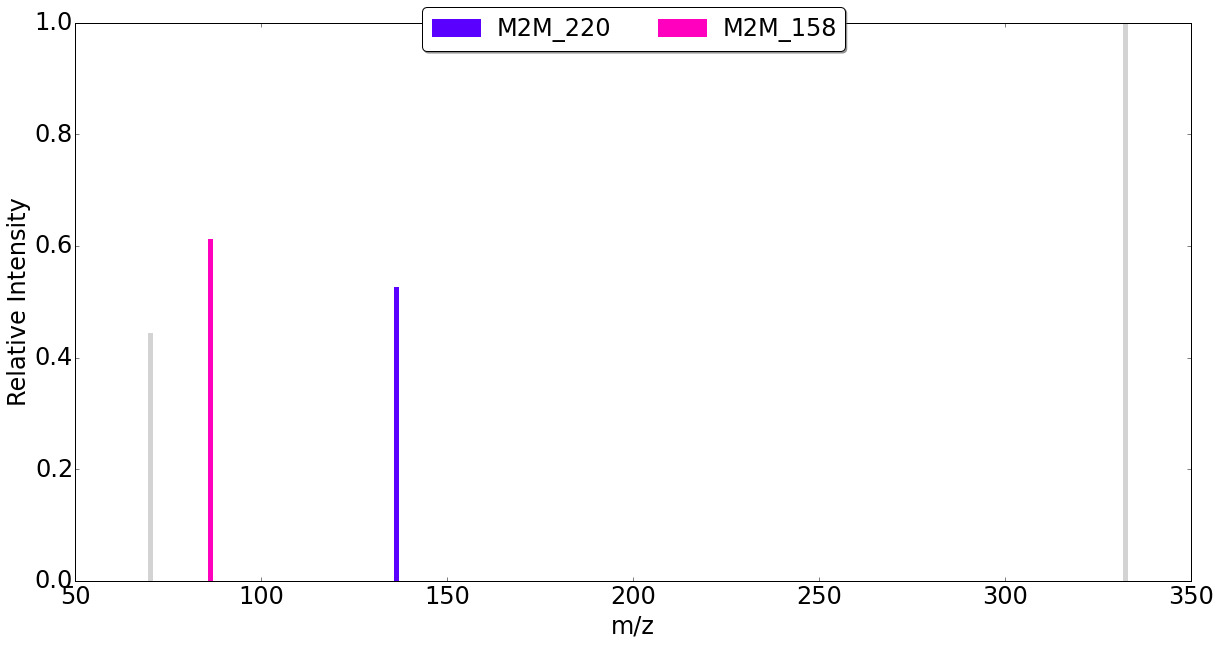

MS1 peakID 25197 mz 318.0951 rt 500.48 intensity 764841.75 (C20H16ONS)
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure



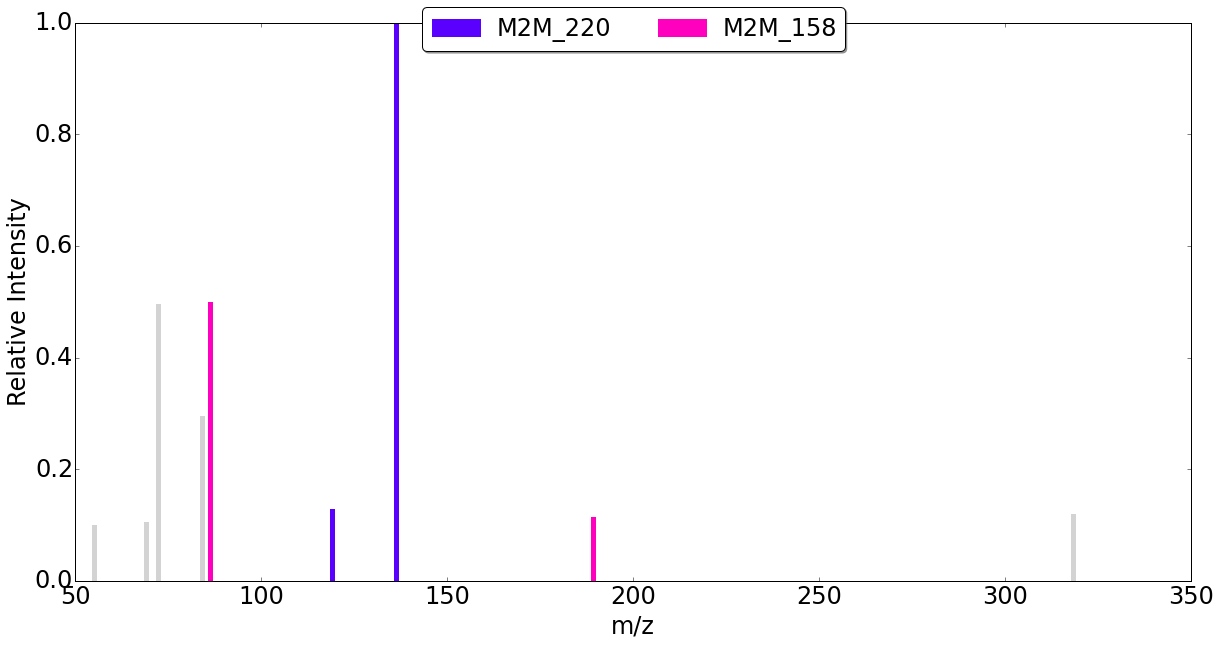

MS1 peakID 33939 mz 553.3097 rt 304.98 intensity 624766.81 (nan)
 - M2M_241	: Histidine substructure
 - M2M_158	: Leucine related substructure



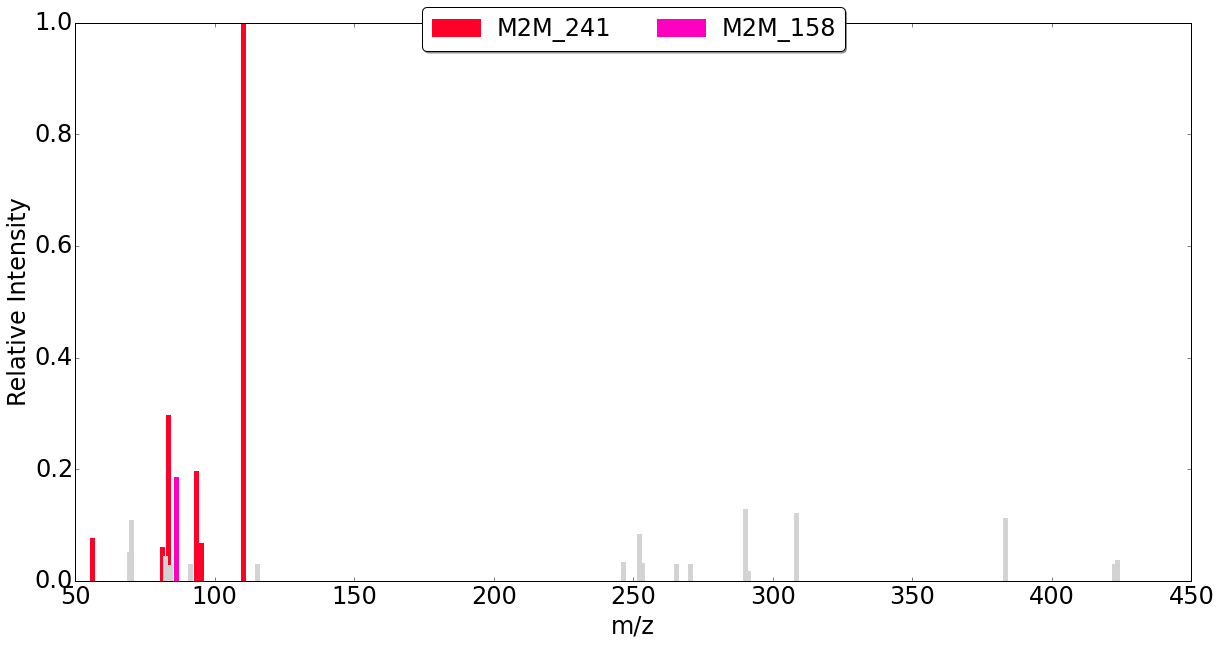

MS1 peakID 17896 mz 261.0943 rt 508.42 intensity 1623367.88 (C7H13O5N6)
 - M2M_202	: Tryptophan related substructure
 - M2M_158	: Leucine related substructure



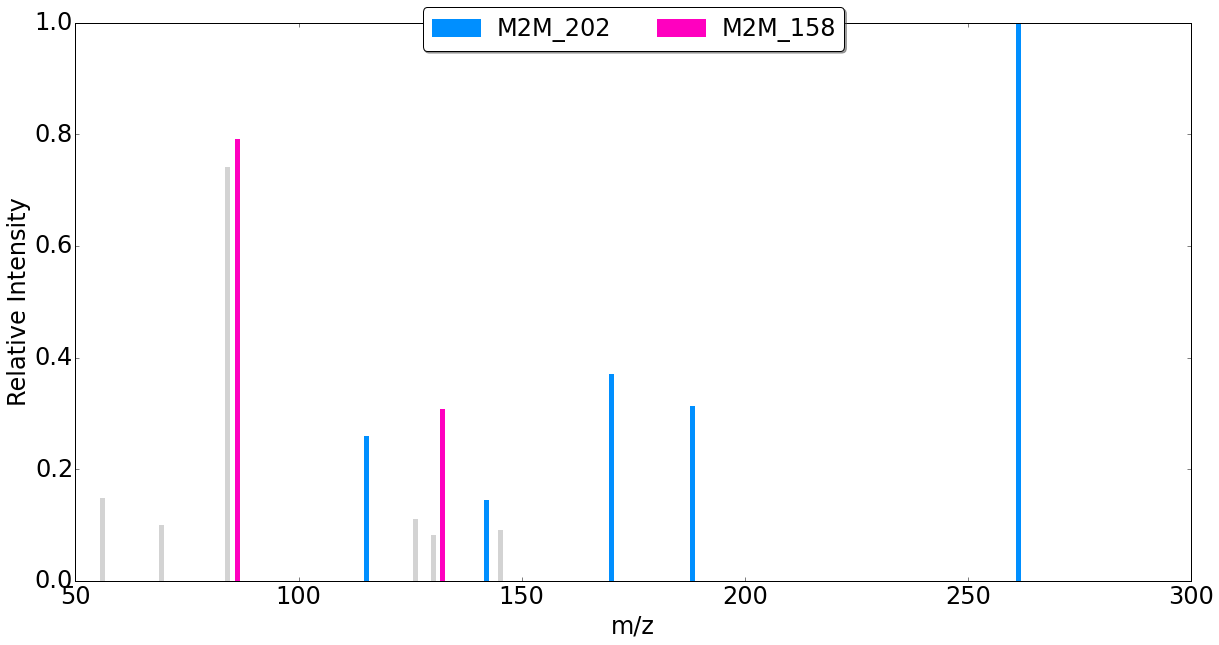

MS1 peakID 2423 mz 132.1020 rt 533.57 intensity 6341282.50 (C6H14O2N)
 - M2M_158	: Leucine related substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



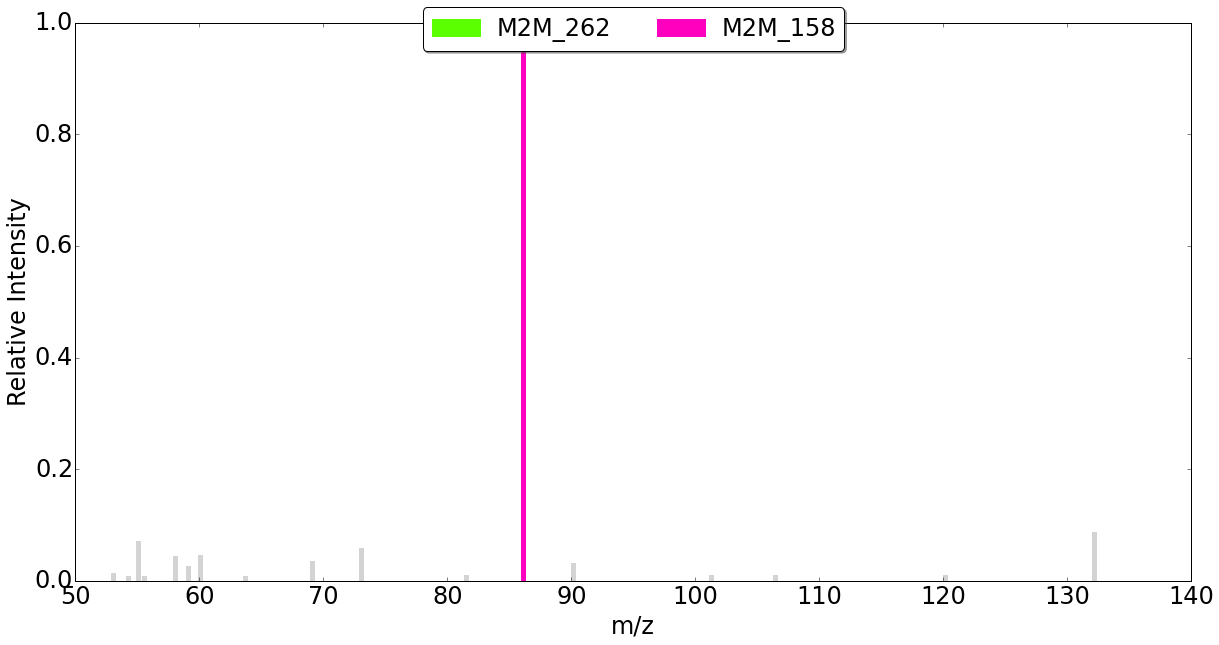

MS1 peakID 23511 mz 300.0845 rt 387.90 intensity 2229831.25 (C20H14NS)
 - M2M_220	: Adenine substructure
 - M2M_158	: Leucine related substructure
 - M2M_55	: Cinnamic acid (cinnamate) substructure



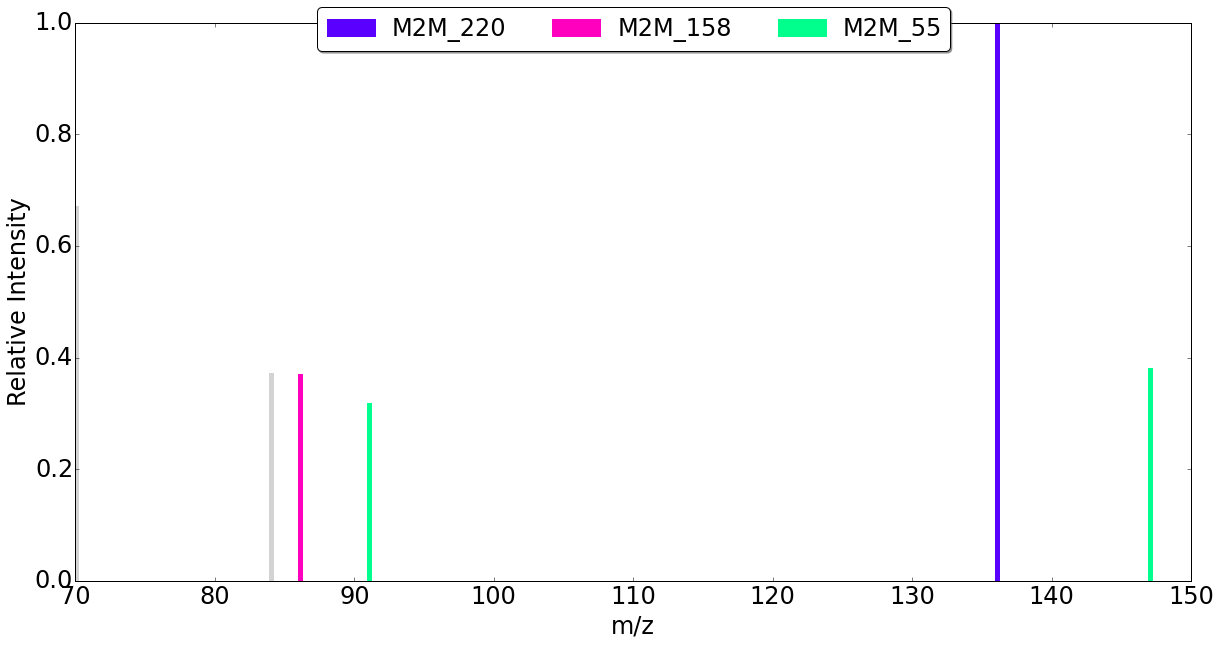

MS1 peakID 12354 mz 222.1124 rt 287.88 intensity 3876743.25 (C12H16O3N)
 - M2M_202	: Tryptophan related substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



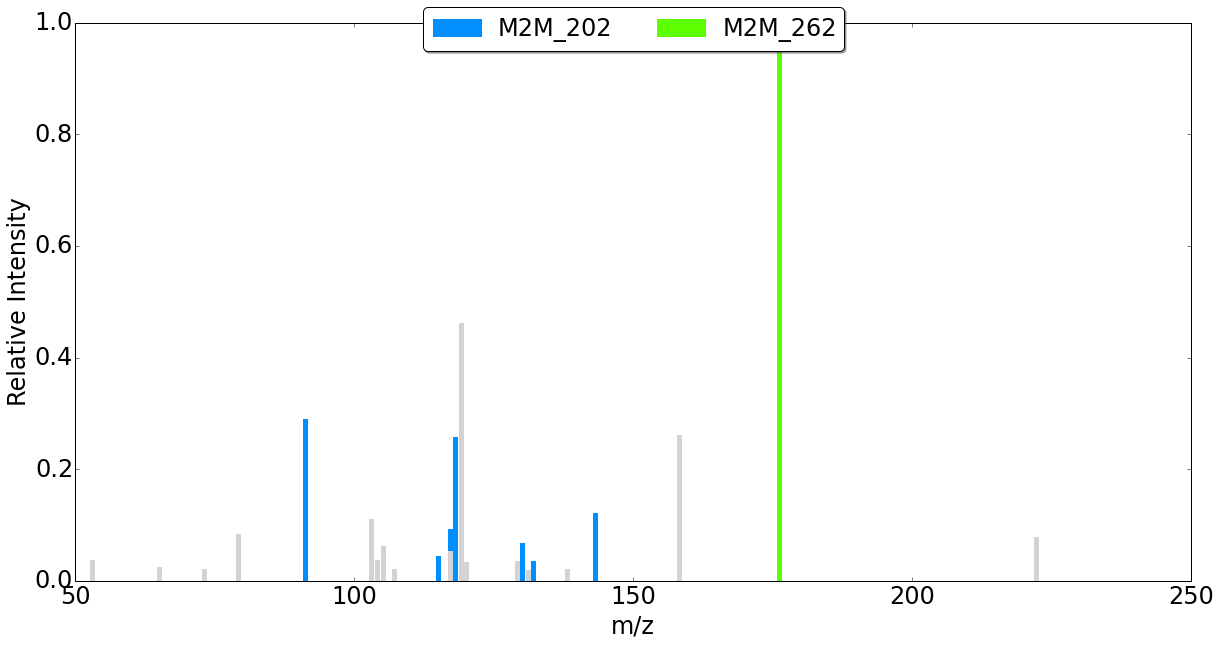

MS1 peakID 10254 mz 204.1232 rt 361.96 intensity 530557.62 (C9H18O4N)
 - M2M_220	: Adenine substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



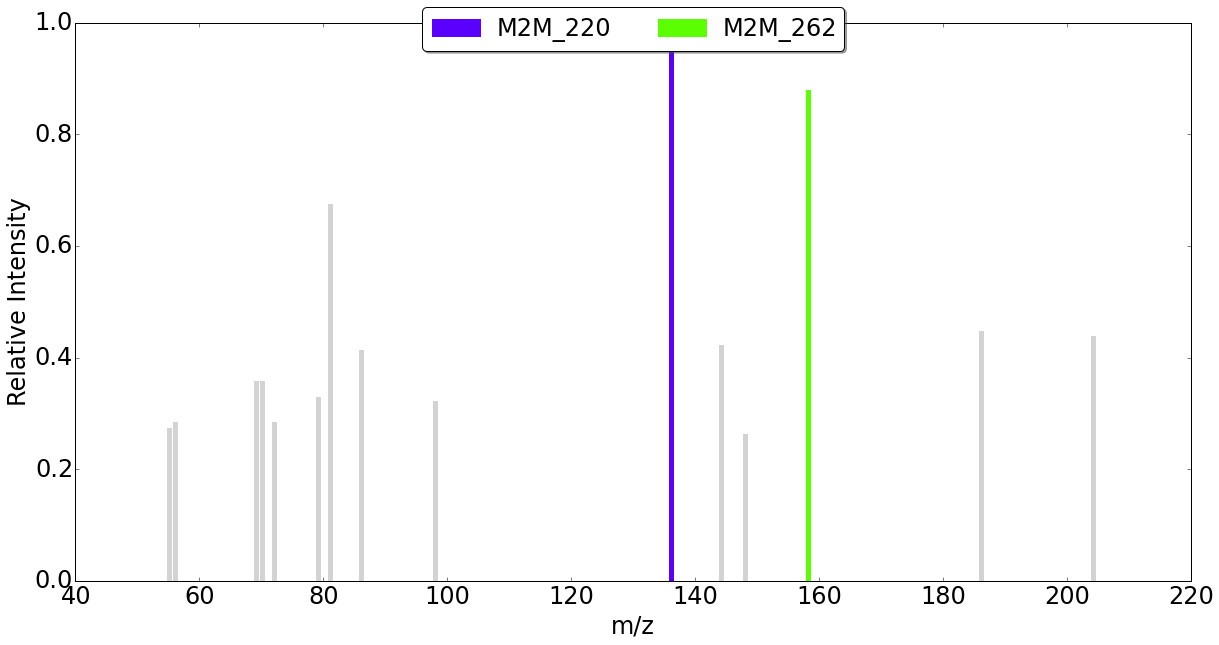

MS1 peakID 4864 mz 157.0801 rt 621.07 intensity 7317130.00 (C5H10O2N3[C13])
 - M2M_241	: Histidine substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



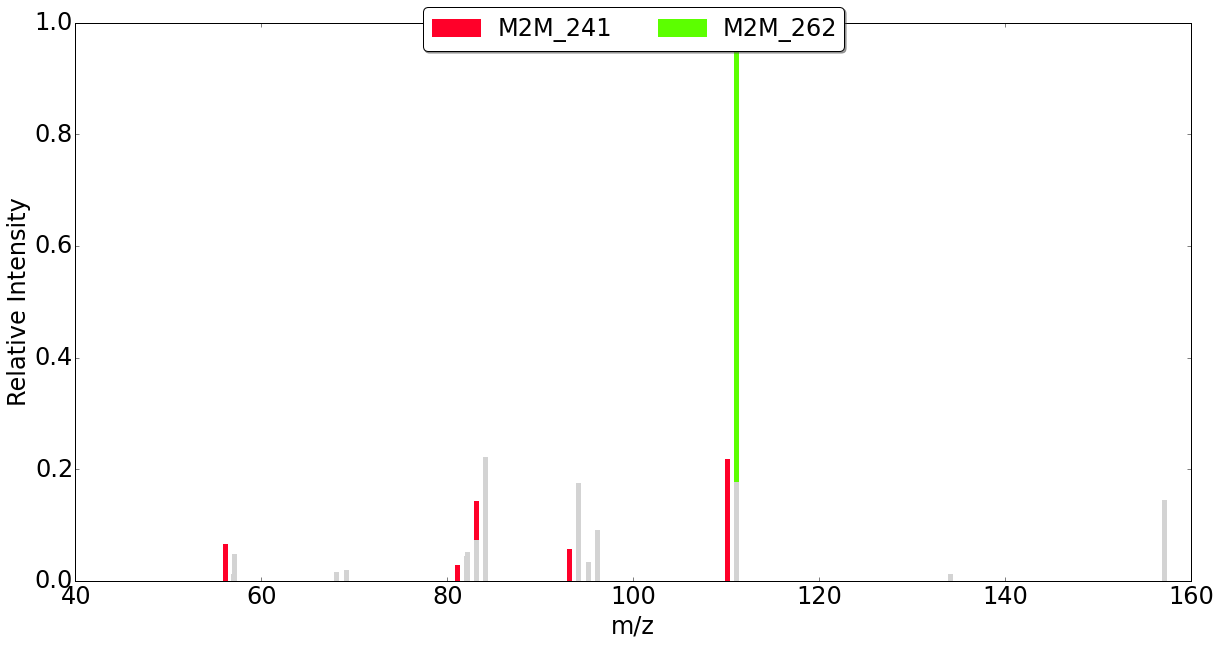

MS1 peakID 11985 mz 218.0811 rt 278.95 intensity 1742296.00 (C12H12O3N)
 - M2M_202	: Tryptophan related substructure
 - M2M_262	: Carboxylic acid group (COOH) - generic substructure in amino acids and organic acids



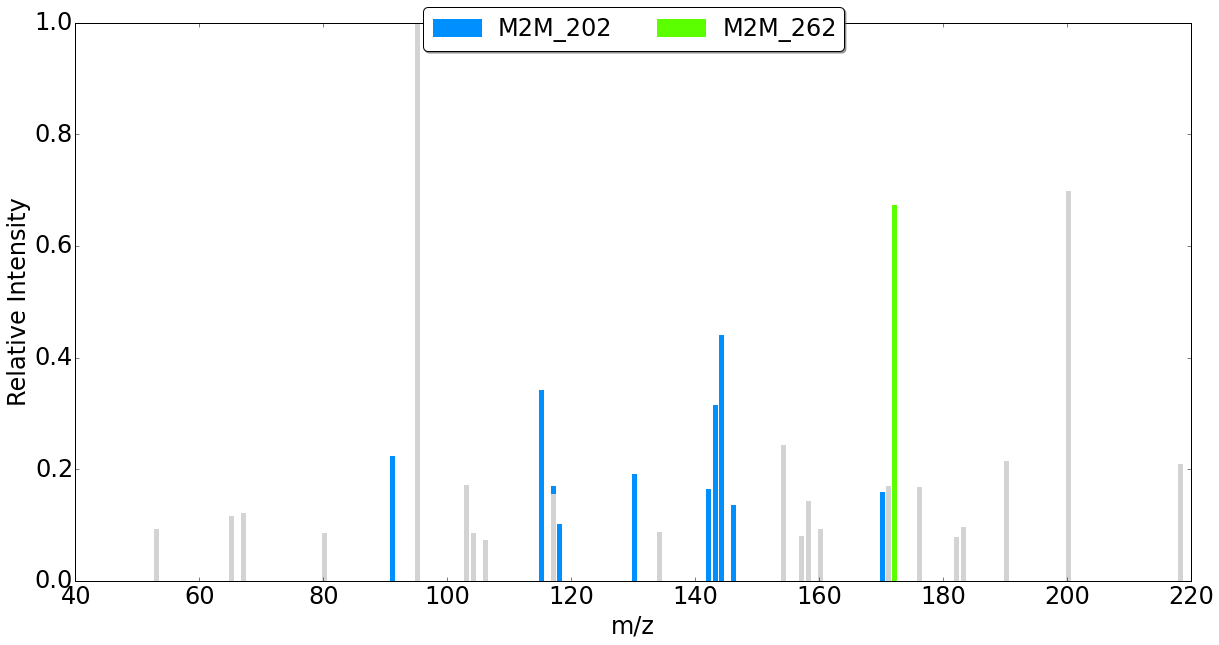

MS1 peakID 33091 mz 471.2238 rt 295.71 intensity 579686.94 (nan)
 - M2M_115	: [phenylalanine-COOH] based substructure
 - M2M_158	: Leucine related substructure



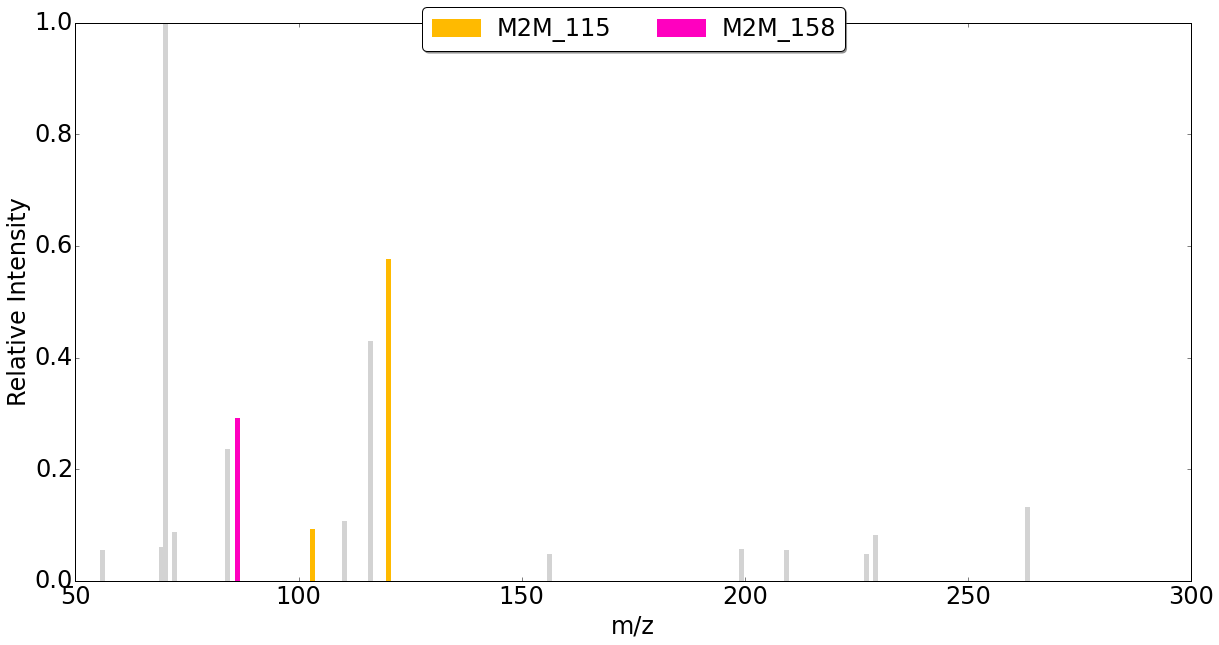

In [13]:
# print all the nodes of interest in the bipartite graph
for node_id in doc_nodes:
    peak_id = int(G.node[node_id]['peakid'])    
    df = print_report(ms2lda, G, peak_id, motif_annotation, motif_colour, motif_idx, word_map)